In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [2]:
#read the data
df = pd.read_csv('AMD.US.csv')

#convert the date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

#sort the data by date
df = df.sort_values('Date')

#print some basic info 
print(f"Data range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Total days: {len(df)}")

Data range: 1983-03-21 00:00:00 to 2024-02-16 00:00:00
Total days: 10312


Recent data range: 2021-02-16 00:00:00 to 2024-02-16 00:00:00
Number of trading days in recent data: 757


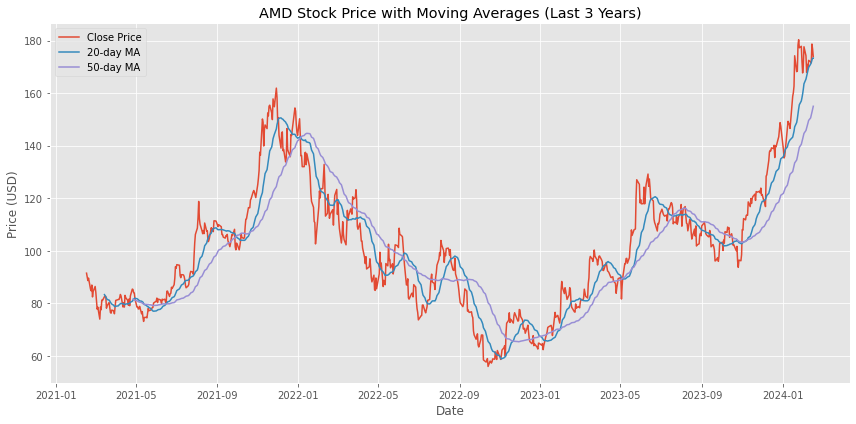

In [4]:
#only focus on the last 3 years of data
three_years_ago = df['Date'].max() - pd.DateOffset(years=3)
recent_df = df[df['Date'] >= three_years_ago].copy()
print(f"Recent data range: {recent_df['Date'].min()} to {recent_df['Date'].max()}")
print(f"Number of trading days in recent data: {len(recent_df)}")

#calculate moving averages
recent_df['MA20'] = recent_df['Close'].rolling(window=20).mean()
recent_df['MA50'] = recent_df['Close'].rolling(window=50).mean()
recent_df['MA200'] = recent_df['Close'].rolling(window=200).mean()

#plot the stock price with moving averages
plt.figure(figsize=(12, 6))
plt.plot(recent_df['Date'], recent_df['Close'], label='Close Price')
plt.plot(recent_df['Date'], recent_df['MA20'], label='20-day MA')
plt.plot(recent_df['Date'], recent_df['MA50'], label='50-day MA')
plt.title('AMD Stock Price with Moving Averages (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('amd_moving_averages.png')
plt.show()

In [5]:
#generate signals based on MA crossovers
recent_df['Signal'] = 0  #initialize signal column with zeros

#create a buy signal (1) when MA20 crosses above MA50
recent_df.loc[(recent_df['MA20'] > recent_df['MA50']) & 
             (recent_df['MA20'].shift(1) <= recent_df['MA50'].shift(1)), 'Signal'] = 1

#create a sell signal (-1) when MA20 crosses below MA50
recent_df.loc[(recent_df['MA20'] < recent_df['MA50']) & 
             (recent_df['MA20'].shift(1) >= recent_df['MA50'].shift(1)), 'Signal'] = -1

#print signals
signals = recent_df[recent_df['Signal'] != 0].copy()
print("\nMA Crossover Signals:")
print(signals[['Date', 'Close', 'Signal']].to_string())

#count number of buy and sell signals
buy_signals = len(recent_df[recent_df['Signal'] == 1])
sell_signals = len(recent_df[recent_df['Signal'] == -1])
print(f"\nNumber of buy signals: {buy_signals}")
print(f"Number of sell signals: {sell_signals}")


MA Crossover Signals:
            Date   Close  Signal
9605  2021-04-28   84.02       1
9617  2021-05-14   74.59      -1
9639  2021-06-16   80.11       1
9713  2021-09-30  102.90      -1
9728  2021-10-21  119.33       1
9780  2022-01-05  136.15      -1
9886  2022-06-08  101.90       1
9900  2022-06-29   77.99      -1
9927  2022-08-08  100.07       1
9952  2022-09-13   77.03      -1
10001 2022-11-21   72.46       1
10029 2023-01-03   64.02      -1
10048 2023-01-31   75.15       1
10114 2023-05-05   89.84      -1
10124 2023-05-19  105.82       1
10165 2023-07-20  110.25      -1
10243 2023-11-08  113.59       1

Number of buy signals: 9
Number of sell signals: 8



Market Return (Buy & Hold): 90.10%
MA Crossover Strategy Return: 29.11%


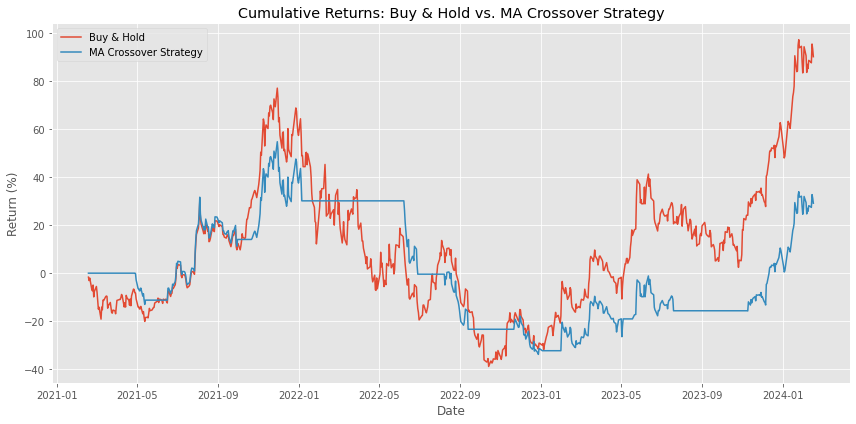

In [6]:
#calculate returns for a simple MA crossover strategy
#create a new position column: 1 means we're invested, 0 means we're not
recent_df['Position'] = 0

#after a buy signal, were invested until we get a sell signal
position = 0  #start with no position
for i in range(len(recent_df)):
    if recent_df['Signal'].iloc[i] == 1:  #buy signal
        position = 1
    elif recent_df['Signal'].iloc[i] == -1:  #sell signal
        position = 0
    recent_df['Position'].iloc[i] = position

#calculate the daily returns
recent_df['Daily_Return'] = recent_df['Close'].pct_change()

#calculate strategy returns (we earn returns only when we have a position)
recent_df['Strategy_Return'] = recent_df['Position'].shift(1) * recent_df['Daily_Return']

#calculate cumulative returns
recent_df['Cumulative_Market_Return'] = (1 + recent_df['Daily_Return']).cumprod() - 1
recent_df['Cumulative_Strategy_Return'] = (1 + recent_df['Strategy_Return']).cumprod() - 1

#print performance stats
market_return = recent_df['Cumulative_Market_Return'].iloc[-1] * 100
strategy_return = recent_df['Cumulative_Strategy_Return'].iloc[-1] * 100

print(f"\nMarket Return (Buy & Hold): {market_return:.2f}%")
print(f"MA Crossover Strategy Return: {strategy_return:.2f}%")

#plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(recent_df['Date'], recent_df['Cumulative_Market_Return'] * 100, label='Buy & Hold')
plt.plot(recent_df['Date'], recent_df['Cumulative_Strategy_Return'] * 100, label='MA Crossover Strategy')
plt.title('Cumulative Returns: Buy & Hold vs. MA Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('strategy_performance.png')
plt.show()

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np

#prepare data for LSTM, focus on the closing price
data = recent_df['Close'].values.reshape(-1, 1)

#scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

#create sequences for LSTM (looking back 20 days to predict the next day)
def create_dataset(data, time_step=20):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step, 0])
        y.append(data[i+time_step, 0])
    return np.array(X), np.array(y)

#split into train and test sets (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data = scaled_data[0:train_size]
test_data = scaled_data[train_size-20:len(scaled_data)]

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (585, 20, 1)
Testing data shape: (152, 20, 1)


In [8]:
#create LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(20, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

#train model
model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1)

#make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

#invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

#calculate RMSE and MAPE
rmse = np.sqrt(np.mean((test_predict - y_test_scaled)**2))
mape = np.mean(np.abs((y_test_scaled - test_predict) / y_test_scaled)) * 100

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

Train on 585 samples
Epoch 1/5
585/585 [==============================] - 5s 9ms/sample - loss: 0.0437
Epoch 2/5
585/585 [==============================] - 1s 1ms/sample - loss: 0.0062
Epoch 3/5
585/585 [==============================] - 2s 3ms/sample - loss: 0.0040
Epoch 4/5
585/585 [==============================] - 2s 3ms/sample - loss: 0.0034
Epoch 5/5
585/585 [==============================] - 2s 3ms/sample - loss: 0.0030
Root Mean Squared Error: 6.96
Mean Absolute Percentage Error: 4.27%


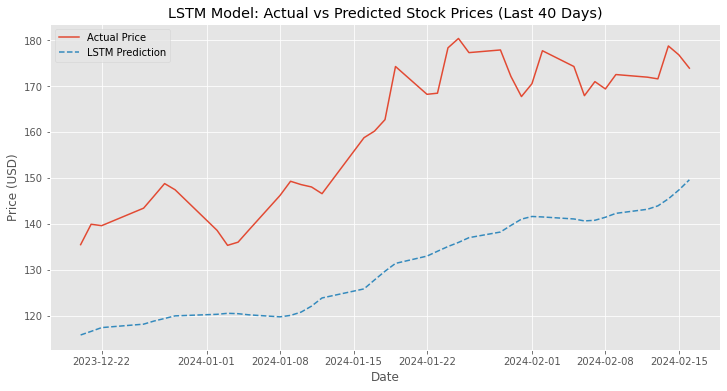

Root Mean Squared Error: 30.02
Mean Absolute Percentage Error: 18.04%


In [13]:
#get the last 60 days of data
last_60_days = recent_df.iloc[-60:].copy()

#make predictions for the 60 days
predictions = []

#for each day in the last 60 days (except the last 20 which don't have enough history)
for i in range(len(last_60_days) - 20):
    #get the previous 20 days of the scaled data
    sequence = scaled_data[-(60-i)-20:-(60-i)]
    sequence = sequence.reshape(1, 20, 1)
    
    #predict the next day
    pred = model.predict(sequence)[0][0]
    
    #append the prediction
    predictions.append(pred)

#convert predictions back to original scale
predictions_scaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

#create dataframe for plotting
plot_df = pd.DataFrame({
    'Date': last_60_days.iloc[20:]['Date'].values,
    'Actual': last_60_days.iloc[20:]['Close'].values,
    'Predicted': predictions_scaled.flatten()
})

#plot results
plt.figure(figsize=(12, 6))
plt.plot(plot_df['Date'], plot_df['Actual'], label='Actual Price')
plt.plot(plot_df['Date'], plot_df['Predicted'], label='LSTM Prediction', linestyle='--')
plt.title('LSTM Model: Actual vs Predicted Stock Prices (Last 40 Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig('lstm_predictions.png')
plt.show()

#calculate errorr on this subset
actual = plot_df['Actual'].values
predicted = plot_df['Predicted'].values
mape = np.mean(np.abs((actual - predicted) / actual)) * 100
rmse = np.sqrt(np.mean((actual - predicted)**2))

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")


LSTM Model 30-Day Forecast:
        Date  Predicted_Price
0 2024-02-19       174.927216
1 2024-02-20       175.277023
2 2024-02-21       175.605606
3 2024-02-22       175.917786
4 2024-02-23       176.229431


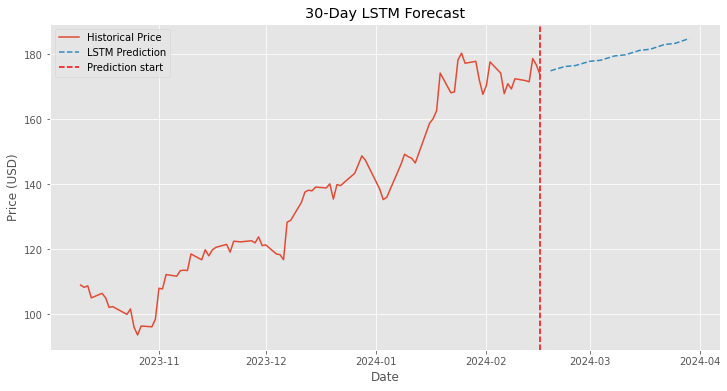


Conclusion:
Current price: $173.87
Forecasted price after 30 days: $184.87
Expected change: 6.33%


In [20]:
#make future predictions
#get the last 20 days of data for prediction
last_20_days = scaled_data[-20:].reshape(1, 20, 1)

#predict the next 30 days
future_days = 30
future_prices = []
current_batch = last_20_days

for _ in range(future_days):
    #get prediction for next day
    current_pred = model.predict(current_batch)[0]
    #add to future prices
    future_prices.append(current_pred)
    #update the batch to include the new prediction
    current_batch = np.append(current_batch[:, 1:, :], 
                             [[current_pred]], 
                             axis=1)

#convert the predictions back to original scale
future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))

#create future dates
last_date = recent_df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=30, freq='B')
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_prices.flatten()
})

print("\nLSTM Model 30-Day Forecast:")
print(future_df.head())

#plot
plt.figure(figsize=(12, 6))
plt.plot(recent_df['Date'][-90:], recent_df['Close'][-90:], label='Historical Price')
plt.plot(future_df['Date'], future_df['Predicted_Price'], label='LSTM Prediction', linestyle='--')
plt.axvline(x=last_date, color='red', linestyle='--', label='Prediction start')
plt.title('30-Day LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig('lstm_forecast.png')
plt.show()

print("\nConclusion:")
print(f"Current price: ${recent_df['Close'].iloc[-1]:.2f}")
print(f"Forecasted price after 30 days: ${future_df['Predicted_Price'].iloc[-1]:.2f}")
print(f"Expected change: {((future_df['Predicted_Price'].iloc[-1] / recent_df['Close'].iloc[-1]) - 1) * 100:.2f}%")

In [14]:
def analyze_ma_crossover(df, short_window, long_window):
    #reate a copy of the dataframe
    data = df.copy()
    
    #calculate the moving averages
    data[f'MA{short_window}'] = data['Close'].rolling(window=short_window).mean()
    data[f'MA{long_window}'] = data['Close'].rolling(window=long_window).mean()
    
    #create signals
    data['Signal'] = 0
    
    #buy signal: short MA crosses above long MA
    data.loc[(data[f'MA{short_window}'] > data[f'MA{long_window}']) & 
             (data[f'MA{short_window}'].shift(1) <= data[f'MA{long_window}'].shift(1)), 'Signal'] = 1
    
    #sell signal: short MA crosses below long MA
    data.loc[(data[f'MA{short_window}'] < data[f'MA{long_window}']) & 
             (data[f'MA{short_window}'].shift(1) >= data[f'MA{long_window}'].shift(1)), 'Signal'] = -1
    
    #count up signals
    buy_signals = len(data[data['Signal'] == 1])
    sell_signals = len(data[data['Signal'] == -1])
    
    #determine position
    data['Position'] = 0
    position = 0
    for i in range(len(data)):
        if data['Signal'].iloc[i] == 1:
            position = 1
        elif data['Signal'].iloc[i] == -1:
            position = 0
        data['Position'].iloc[i] = position
    
    #calculate returns
    data['Daily_Return'] = data['Close'].pct_change()
    data['Strategy_Return'] = data['Position'].shift(1) * data['Daily_Return']
    
    #calculate cumulative returns
    data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod() - 1
    
    #calculate final return
    strategy_return = data['Cumulative_Strategy_Return'].iloc[-1] * 100
    
    return {
        'ma_combination': f"MA{short_window}/{long_window}",
        'buy_signals': buy_signals,
        'sell_signals': sell_signals,
        'strategy_return': strategy_return,
        'cumulative_returns': data['Cumulative_Strategy_Return']
    }

#test different MA combos
ma_combinations = [
    (5, 20),
    (10, 50),
    (20, 50),
    (50, 200)
]

results = []
for short_window, long_window in ma_combinations:
    result = analyze_ma_crossover(recent_df, short_window, long_window)
    results.append(result)
    
    print(f"\nMA {short_window}/{long_window} Strategy:")
    print(f"Buy signals: {result['buy_signals']}")
    print(f"Sell signals: {result['sell_signals']}")
    print(f"Strategy return: {result['strategy_return']:.2f}%")


MA 5/20 Strategy:
Buy signals: 24
Sell signals: 23
Strategy return: 77.99%

MA 10/50 Strategy:
Buy signals: 10
Sell signals: 10
Strategy return: 25.31%

MA 20/50 Strategy:
Buy signals: 9
Sell signals: 8
Strategy return: 29.11%

MA 50/200 Strategy:
Buy signals: 1
Sell signals: 1
Strategy return: 79.99%


In [16]:
#calculate how accurate the different MA strategies are as trend predictors
for result in results:
    ma_name = result['ma_combination']
    signals_df = recent_df[recent_df['Signal'] != 0].copy()
    
    #calculate how many signals were followed by price moving in the expected direction
    correct_predictions = 0
    total_signals = len(signals_df)
    
    if total_signals > 0:
        for i in range(total_signals):
            signal = signals_df['Signal'].iloc[i]
            current_price = signals_df['Close'].iloc[i]
            
            #find the price 20 days later (or the last available price)
            future_idx = min(signals_df.index[i] + 20, len(recent_df) - 1)
            future_price = recent_df['Close'].iloc[future_idx]
            
            #check if prediction was correct
            if (signal == 1 and future_price > current_price) or (signal == -1 and future_price < current_price):
                correct_predictions += 1
        
        accuracy = (correct_predictions / total_signals) * 100
        print(f"\n{ma_name} trend prediction accuracy: {accuracy:.2f}%")

print("\nConclusion:")
print(f"Current price: ${recent_df['Close'].iloc[-1]:.2f}")

try:
    print(f"LSTM forecasted price after 30 days: ${future_df['Predicted_Price'].iloc[-1]:.2f}")
    print(f"Expected change: {((future_df['Predicted_Price'].iloc[-1] / recent_df['Close'].iloc[-1]) - 1) * 100:.2f}%")
except NameError:
    print("LSTM forecast not available.")


MA5/20 trend prediction accuracy: 52.94%

MA10/50 trend prediction accuracy: 52.94%

MA20/50 trend prediction accuracy: 52.94%

MA50/200 trend prediction accuracy: 52.94%

Conclusion:
Current price: $173.87
LSTM forecasted price after 30 days: $184.87
Expected change: 6.33%
